In [1]:
import numpy as np
np.set_printoptions(precision=2)
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import ArrayParameter, MultiParameter
from qcodes.instrument.channel import InstrumentChannel, ChannelList
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def print_params(instr):
    for k, v in instr.parameters.items():
        print(k, ': ', v())
        if isinstance(v, ArrayParameter) and v.setpoints is not None:
            print('\t - setpoints: ', v.setpoint_names, v.setpoints)

## Setting up some parameters to be delegates of...

- Make an array parameter that returns an array an (n,) shape array with setpoints

- Make a multi param that returns two values, one a single point and one an array with shape (3,) no setpoints

- Make an instrument channel that has an ArrayParameter and a ManualParameter

- Make an instrument that has a parameter, an array parameter, a multi parameter and two channels

In [3]:
class MyArrayParam(ArrayParameter):
    def __init__(self, name, instrument, start, stop, npts, **kwargs):
        super().__init__(name=name, instrument=instrument, shape=(npts,), **kwargs)
        self.set_up(start, stop, npts)
    
    def set_up(self, start, stop, npts):
        self.setpoints = (tuple(np.linspace(start, stop, npts)), )
        self.setpoint_names = ('array_param_setpoints',)
        self.shape = (npts,)
       
    def get_raw(self):
        return np.random.random(self.shape) * self.setpoints[0]
    
class MyMultiParam(MultiParameter):
    def __init__(self, name, instrument):
        super().__init__(name=name, instrument=instrument, names=('a', 'b'), shapes=((1,), (3,)))
       
    def get_raw(self):
        return np.random.random(), 0.1 * np.arange(3)

class MyInstrumentChannel(InstrumentChannel):
    def __init__(self, parent, name):
        super().__init__(parent=parent, name=name)
        self.add_parameter(name='chan_array_param',
                           parameter_class=MyArrayParam,
                           start=100,
                           stop=5000,
                           npts=4,
                           setpoint_names=('array_param_setpoints',))
        self.add_parameter(name='chan_param',
                           set_cmd=None,
                           initial_value=10)
                       
class MyInstrument(Instrument):
    def __init__(self, name):
        super().__init__(name)
        self.add_parameter(name='param',
                           initial_value=0.5,
                           set_cmd=None,
                           label='Parameter')
        self.add_parameter(name='array_param',
                          parameter_class=MyArrayParam,
                          start=0,
                          stop=10,
                          npts=6,
                          label='Array Param')
        self.add_parameter(name='multi_param',
                          parameter_class=MyMultiParam)
        instr_chan1 = MyInstrumentChannel(self, 'chan1')
        instr_chan2 = MyInstrumentChannel(self, 'chan2')
        chan_list = ChannelList(self, 'chan_list', MyInstrumentChannel, [instr_chan1, instr_chan2])
        self.add_submodule('chan_list', chan_list)

In [4]:
my_instr = MyInstrument('my_instr')

### Check ArrayParam

Text(0, 0.5, 'Array Param')

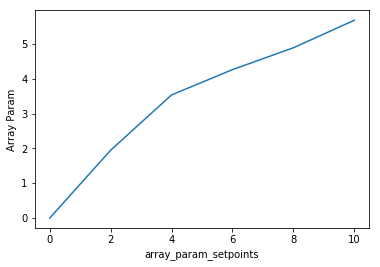

In [5]:
fig = plt.figure()
plt.plot(my_instr.array_param.setpoints[0], my_instr.array_param())
plt.xlabel(my_instr.array_param.setpoint_names[0])
plt.ylabel(my_instr.array_param.label)

### Check Multi Param

In [6]:
print(my_instr.multi_param())
print(my_instr.multi_param.setpoints)

(0.960784361064729, array([0. , 0.1, 0.2]))
None


### Check Channels

In [7]:
print('chan 1')
print_params(my_instr.chan_list[0])
print('chan 2')
print_params(my_instr.chan_list[1])

chan 1
chan_array_param :  [   1.84    7.82  571.61 1616.46]
	 - setpoints:  ('array_param_setpoints',) ((100.0, 1733.3333333333333, 3366.6666666666665, 5000.0),)
chan_param :  10
chan 2
chan_array_param :  [ 15.26 750.67  97.9   44.63]
	 - setpoints:  ('array_param_setpoints',) ((100.0, 1733.3333333333333, 3366.6666666666665, 5000.0),)
chan_param :  10


/Users/natalie/Documents/PhD/Qdev/Qcodes/qcodes/instrument/parameter.py:1218: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


Multi_chan_param 
 ('my_instr_chan1_chan_param', 'my_instr_chan2_chan_param') (10, 10)


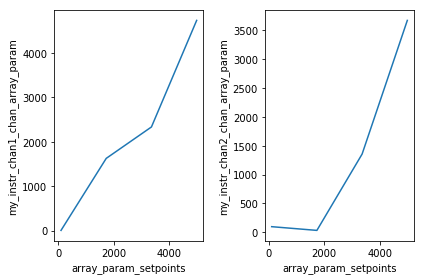

In [8]:
print(my_instr.chan_list.chan_param.name, '\n', my_instr.chan_list.chan_param.names, my_instr.chan_list.chan_param())
fig, axes = plt.subplots(1, 2)
for i, chan_param_val in enumerate(my_instr.chan_list.chan_array_param()):
    axes[i].plot(my_instr.chan_list.chan_array_param.setpoints[i][0], chan_param_val)
    axes[i].set_xlabel(my_instr.chan_list.chan_array_param.setpoint_names[i][0])
    axes[i].set_ylabel(my_instr.chan_list.chan_array_param.full_names[i])
plt.tight_layout()

## Setting up some delegate parameters

In [5]:
from qdev_wrappers.customised_instruments.parameters.delegate_parameters import DelegateParameter, DelegateArrayParameter, DelegateMultiParameter, DelegateMultiChannelParameter

### DelegateParameter

The most intuitive incarnation is when a source parameter is provided and the DelegateParameter merely tracks it. Here I set it up to track the 'param' parameter on my_instr. The unit will match that of the source parameter but I can provide a custom label if desired (defaults to source label).

In [6]:
delegate_param = DelegateParameter('delegate_parameter',
                                   source=my_instr.param,
                                   label='My Special Delegate Parameter')

In [7]:
my_instr.param(0.5)
delegate_param()
print(my_instr.param._latest)
print(delegate_param._latest)
delegate_param(2.5)
print(my_instr.param._latest)
print(delegate_param._latest)

{'value': 0.5, 'ts': datetime.datetime(2019, 1, 11, 15, 22, 48, 392973), 'raw_value': 0.5}
{'value': 0.5, 'ts': datetime.datetime(2019, 1, 11, 15, 22, 48, 392981), 'raw_value': 0.5}
{'value': 2.5, 'ts': datetime.datetime(2019, 1, 11, 15, 22, 48, 393524), 'raw_value': 2.5}
{'value': 2.5, 'ts': datetime.datetime(2019, 1, 11, 15, 22, 48, 393532), 'raw_value': 2.5}


In [8]:
print(my_instr.param.label)
print(delegate_param.label)

Parameter
My Special Delegate Parameter


Getting or setting can be prohibited for any kwarg combination by means of the kwargs get_allowed and set_allowed.

In [9]:
delegate_param = DelegateParameter('delegate_parameter',
                                   source=my_instr.param,
                                   set_allowed=False,
                                   get_allowed=False)
try:
    delegate_param(2)
except RuntimeError as e:
    print(e)

try:
    delegate_param()
except RuntimeError as e:
    print(e)

('Parmeter delegate_parameter not settable', 'setting delegate_parameter to 2')
('Parmeter delegate_parameter not gettable', 'getting delegate_parameter')


If a source is not provided then the behaviour is controlled by the kwargs 'random_return', 'get_fn' and 'set_fn'. The default behaviour is for the parameter to behave like a manual parameter as below.

In [10]:
delegate_param = DelegateParameter('delegate_parameter', get_fn=None, set_fn=None, random_return=False)

In [11]:
delegate_param(3)
print(delegate_param._latest)
print(delegate_param())

{'value': 3, 'ts': datetime.datetime(2019, 1, 11, 15, 22, 52, 336646), 'raw_value': 3}
3


It is also possible to provide a set_fn which will be executed before the value is set and a get function to choose what to return.

In [12]:
delegate_param = DelegateParameter('delegate_parameter',
                                   set_fn=lambda x: print('setting ', x),
                                   get_fn=lambda: 12)

In [13]:
delegate_param(3)
print(delegate_param._latest)
print(delegate_param())

setting  3
{'value': 3, 'ts': datetime.datetime(2019, 1, 11, 15, 22, 53, 884009), 'raw_value': 3}
12


Setting the 'random_return' kwarg to True is equivalent to setting the get_fn to be a random generator

In [14]:
delegate_param = DelegateParameter('delegate_parameter',
                                   random_return=True)

In [15]:
delegate_param(3)
print(delegate_param._latest)
print(delegate_param())

{'value': 3, 'ts': datetime.datetime(2019, 1, 11, 15, 22, 55, 317012), 'raw_value': 3}
0.5728311587041972


### DelegateArrayParameter

Since ArrayParameters are not settable this one is a bit simpler and there is no 'set_fn' or 'set_allowed' kwargs. If a source is provided then the unit, shape and setpoint information is copied from the source parameter. The 'label' can be provided or defaults to that of the source.

In [16]:
delegate_array_param = DelegateArrayParameter('delegate_array_parameter',
                                              source=my_instr.array_param,
                                              label='my_special_label')

In [17]:
delegate_array_param()
print(delegate_array_param.get_latest())
print(my_instr.array_param.get_latest())
print(delegate_array_param.setpoint_names)
print(my_instr.array_param.setpoint_names)

[0.   0.4  2.54 3.6  3.38 2.52]
[0.   0.4  2.54 3.6  3.38 2.52]
('array_param_setpoints',)
('array_param_setpoints',)


As before getting can be prohibited by setting the get_allowed to False. Set is already prohibited.

In [18]:
delegate_array_param = DelegateArrayParameter('delegate_array_parameter',
                                              source=my_instr.array_param,
                                              get_allowed=False)
try:
    delegate_array_param()
except RuntimeError as e:
    print(e)

try:
    delegate_array_param(2)
except RuntimeError as e:
    print(e)

('Parmeter delegate_array_parameter not gettable', 'getting delegate_array_parameter')
no set cmd found in Parameter delegate_array_parameter


If no source is provided then there is no option of saved values since setting is not allowed. By default a random array of the relevant shape is returned. The user must take care of minimally the shape but also setpoint information, unit and label if desired.

In [19]:
delegate_array_param = DelegateArrayParameter('delegate_array_parameter',
                                              setpoints=tuple((np.arange(15),)),
                                              setpoint_names=('my_setpoints',),
                                              setpoint_labels=None,
                                              setpoint_units=('G',),
                                              label='My Very Special Parameter',
                                              unit='V',
                                              shape=(15,))

In [20]:
print(delegate_array_param())
print(delegate_array_param.setpoints)

[0.68 0.44 0.97 0.59 0.33 0.28 0.08 0.13 0.94 0.34 0.01 0.27 0.93 0.95
 0.49]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),)


A Callable get_fn is available as before (slightly less trivial as you should also maintain the shape of the Parameter in order not to break things). It can be provided via the init or set at any time.

In [21]:
delegate_array_param = DelegateArrayParameter('delegate_array_parameter',
                                              shape=(10,),
                                              get_fn=lambda: np.arange(10))
print(delegate_array_param())
delegate_array_param.shape = (5,)
delegate_array_param.get_fn = lambda: np.arange(5)
print(delegate_array_param())

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4]


### DelegateMultiParameter

Similarly the DelegateMultiParameter can interface with a MultiParameter or used to simulate one. Names, units and setpoint information is copied for the source but again the 'labels' can be set.

In [6]:
delegate_multi_param = DelegateMultiParameter('delegate_multi_parameter',
                                              source=my_instr.multi_param)

In [7]:
delegate_multi_param()
print(delegate_multi_param.get_latest())
print(my_instr.multi_param.get_latest())

(0.17439715388069732, array([0. , 0.1, 0.2]))
(0.17439715388069732, array([0. , 0.1, 0.2]))


As before get can be prohibited using the 'get_allowed' kwarg. If no source is provided then again the result defaults to being a random array matching the shapes or a callable get_fn can be provided.

In [13]:
delegate_multi_param = DelegateMultiParameter('delegate_multi_parameter',
                                              shapes=((15,), (1,)),
                                             get_fn=None)

In [14]:
delegate_multi_param()

(array([0.59, 0.19, 0.93, 0.13, 0.52, 0.97, 0.53, 0.55, 0.39, 0.71, 0.05,
        0.87, 0.47, 0.16, 0.71]), array([0.13]))

In [15]:
delegate_multi_param = DelegateMultiParameter('delegate_multi_parameter',
                                              shapes=((15,), (1,)),
                                              get_fn = lambda: tuple((np.arange(15), np.array([12]))))

In [16]:
delegate_multi_param()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([12]))

### DelegateMultiChannelParameter

A DelegateMultiChannelParameter can be used to track a MultiChannelParameter. If you really wanted to simulate this you should also simulate the underlying channels and their parameters so there is no 'simulation' for this parameter, you have to give it a channelist and paramname which are the equivalent of giving a source to another parameter.  

In [6]:
delegate_multi_chan_param = DelegateMultiChannelParameter('delegate_multi_chan_parameter',
                                                          channels=my_instr.chan_list,
                                                          param_name='chan_param')

/Users/natalie/Documents/PhD/Qdev/Qcodes/qcodes/instrument/parameter.py:1218: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


In [7]:
print(delegate_multi_chan_param())
print(my_instr.chan_list.chan_param())

(10, 10)
(10, 10)


Setting it will result in the underlying channels being all set to this value

In [8]:
delegate_multi_chan_param(1)
print(delegate_multi_chan_param())
print(my_instr.chan_list.chan_param())

(1, 1)
(1, 1)


Getting and setting can be prohibited using the 'get_allowed' and 'set_allowed' kwargs (or attributes)

In [9]:
delegate_multi_chan_param.get_allowed = False
delegate_multi_chan_param.set_allowed = False

try:
    delegate_multi_chan_param()
except RuntimeError as e:
    print(e)

try:
    delegate_multi_chan_param(2)
except RuntimeError as e:
    print(e)

('Parmeter delegate_multi_chan_parameter not gettable', 'getting delegate_multi_chan_parameter')
('Parmeter delegate_multi_chan_parameter not settable', 'setting delegate_multi_chan_parameter to 2')


For a multi channel array parameter

In [10]:
delegate_multi_chan_param = DelegateMultiChannelParameter('delegate_multi_chan_parameter',
                                                          channels=my_instr.chan_list,
                                                          param_name='chan_array_param')

(NB each call generates a new random list so it's still working!).

In [11]:
print(delegate_multi_chan_param())
print(my_instr.chan_list.chan_array_param())

(array([  55.82,   73.35,  656.83, 3876.5 ]), array([  63.54,  127.35, 1011.03,  542.12]))
(array([  51.  ,   19.02, 2408.68, 4732.57]), array([  61.9 , 1334.55, 2749.16,   92.65]))


Checking that names, setpoint names and setpoints are also copied

In [12]:
print(delegate_multi_chan_param.names)
print(my_instr.chan_list.chan_array_param.names)
print(delegate_multi_chan_param.setpoint_names)
print(my_instr.chan_list.chan_array_param.setpoints)
print(delegate_multi_chan_param.setpoints)

('my_instr_chan1_chan_array_param', 'my_instr_chan2_chan_array_param')
('my_instr_chan1_chan_array_param', 'my_instr_chan2_chan_array_param')
(('array_param_setpoints',), ('array_param_setpoints',))
(((100.0, 1733.3333333333333, 3366.6666666666665, 5000.0),), ((100.0, 1733.3333333333333, 3366.6666666666665, 5000.0),))
(((100.0, 1733.3333333333333, 3366.6666666666665, 5000.0),), ((100.0, 1733.3333333333333, 3366.6666666666665, 5000.0),))


And updated... NB the delegate parameter attributes will only be updated when it is called

In [13]:
print(my_instr.chan_list.chan_array_param.setpoint_names)
print(delegate_multi_chan_param.setpoint_names)
my_instr.chan_list.chan1.chan_array_param.setpoint_names = ('new_setpoints',)
delegate_multi_chan_param()
print(my_instr.chan_list.chan_array_param.setpoint_names)
print(delegate_multi_chan_param.setpoint_names)

(('array_param_setpoints',), ('array_param_setpoints',))
(('array_param_setpoints',), ('array_param_setpoints',))
(('new_setpoints',), ('array_param_setpoints',))
(('new_setpoints',), ('array_param_setpoints',))


The main use of this parameter is to create something that sticks around as compared to the QCoDeS implementation of a multi channel parameter which creates a new instance every time it is accessed. The addition of being able to prohibit getting and setting is just for possible future use